# 합성곱 신경망을 사용한 이미지 분류

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/hg-mldl/blob/master/8-2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

#수업시간에 배운 CNN을 이용하여 이미지를 분류해 보자!!!


데이터 셋 정보: http://yann.lecun.com/exdb/mnist/

## MNIST 데이터 셋 읽어오기

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt



(train_input, train_target), (test_input, test_target) = \
    keras.datasets.mnist.load_data()


11490434/11490434 [==============================] - 0s 0us/step


##로드한 데이터의 shape을 확인하시오 (샘플 수: 60000, 28 x 28).
##데이터 셋의 클래스 수를 확인하시오 (numpy unique() 활용 - 7일차 교육 MNIST 실습의 데이터 준비 슬라이드 참고)

In [2]:
print(train_input.shape)
print(np.unique(train_target))

(60000, 28, 28)
[0 1 2 3 4 5 6 7 8 9]


## 이미지에 깊이 1을 추가하고, 픽셀값을 0~1값으로 정규화하시오


In [3]:
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0

##데이터 세트를 훈련데이터 (80%)와 검증세트로 분리하시오

In [4]:
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

#분류가 잘 되었는지 확인하시오 (훈련 세트 = 48000, 검증세트 = 12000)

In [5]:
print(train_scaled.shape)

(48000, 28, 28, 1)


## matplotlib의 imshow() 메소드를 사용하여 정규화된 훈련세트의 5번째 인덱스의 이미지를 color bar와 함께 출력하시오. 

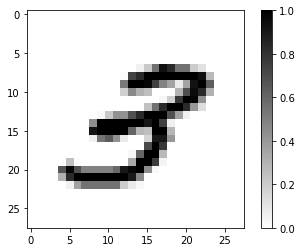

In [6]:
import matplotlib.pyplot as plt
plt.imshow(train_scaled[5].reshape(28,28), cmap="gray_r") #변수명은 변경 가능
plt.colorbar()
plt.show()

## 합성곱 신경망 만들기

In [7]:
model = keras.Sequential()

##첫번째 합성곱 층을 생성후 모델에 추가하시오.
필터 수: 32개\
필터 (커널) 사이즈: 3 x 3 x 1\
활성화 함수: ReLU\
패딩: same padding\
stride: 1\
input_shape는 데이터 특성에 맞게 지정

In [8]:
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu', 
                              padding='same', input_shape=(28,28,1)))

## 2x2 최대 풀링 (max pooling) 층을 추가하시오

In [9]:
model.add(keras.layers.MaxPooling2D(2))

##두번째 합성곱 층을 생성 후 모델에 추가하시오
필터 수: 64개\
필터 (커널) 사이즈: 3 x 3 x 32\
활성화 함수: ReLU\
패딩: same padding\
stride: 1

In [10]:
model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', 
                              padding='same'))

## 2x2 최대 풀링 (max pooling) 층을 추가하시오.
stride: 2

In [11]:
model.add(keras.layers.MaxPooling2D(2))

## Flatten 층을 추가하고, 출력을 위한 Dense 층 두개를 추가하시오.
## 첫번째 Dense 층 이후에 Dropout 층을 추가하시오 (Dropout율: 30%) 
첫번째 Dense 층의 뉴런 갯수: 100개\
첫번째 Dense 층의 활성화 함수: ReLU\
두번째 Dense 층의 뉴런 갯수: 데이터 특성에 맞게 설정\
두번째 Dense 층의 활성화 함수: Softmax


In [12]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(10, activation='softmax'))

##model.summary()를 사용하여 모델이 잘 구성되었는지 확인

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

##utils.plot_model()을 사용하여 모델이 잘 구성되었는지 확인

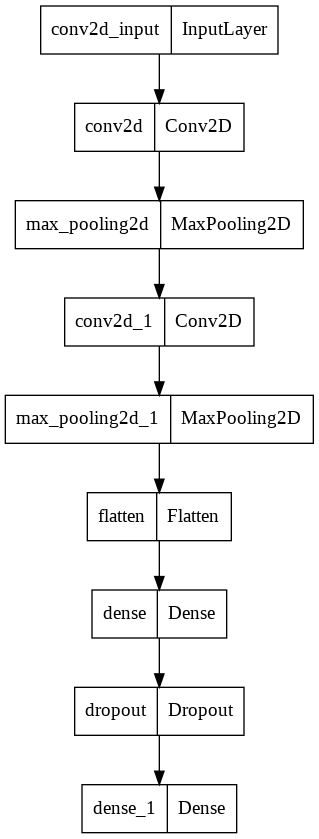

In [14]:
keras.utils.plot_model(model)

## 모델 컴파일과 훈련
optimizer: adam\
손실함수: 다중분류를 위한 함수로 지정\
accuracy 메트릭 추가

In [15]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')


## ModelCheckPoint 콜백 및 Early_stopping 콜백 사용을 사용하여 최적의 모델을 찾고 저장하시오.
##에포크는 적당히 큰 값으로 설정 (예: 30)
## patience: 2

In [16]:

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 77s 50ms/step - loss: 0.2019 - accuracy: 0.9388 - val_loss: 0.0565 - val_accuracy: 0.9843
Epoch 2/20
1500/1500 [==============================] - 70s 47ms/step - loss: 0.0731 - accuracy: 0.9782 - val_loss: 0.0438 - val_accuracy: 0.9877
Epoch 3/20
1500/1500 [==============================] - 69s 46ms/step - loss: 0.0532 - accuracy: 0.9841 - val_loss: 0.0368 - val_accuracy: 0.9890
Epoch 4/20
1500/1500 [==============================] - 69s 46ms/step - loss: 0.0404 - accuracy: 0.9875 - val_loss: 0.0428 - val_accuracy: 0.9891
Epoch 5/20
1500/1500 [==============================] - 69s 46ms/step - loss: 0.0322 - accuracy: 0.9897 - val_loss: 0.0361 - val_accuracy: 0.9897
Epoch 6/20
1500/1500 [==============================] - 69s 46ms/step - loss: 0.0280 - accuracy: 0.9910 - val_loss: 0.0345 - val_accuracy: 0.9906
Epoch 7/20
1500/1500 [==============================] - 68s 46ms/step - loss: 0.0226 - accuracy: 0.9924 - val_loss: 0.0380 -

## matplotlib를 사용하여 학습 세트와 검증세트의 Loss율을 확인하시오.

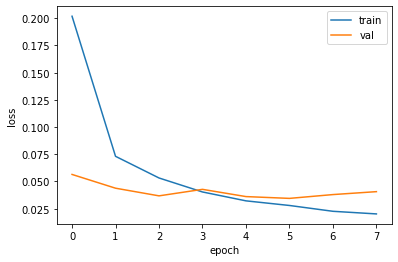

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## model.evaluate()를 사용하여 검증 세트에 대한 성능을 측정하시오

In [18]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 5s 14ms/step - loss: 0.0345 - accuracy: 0.9906


[0.03446713835000992, 0.9905833601951599]

##검증세트의 두번째 (인덱스 1) 이미지 출력

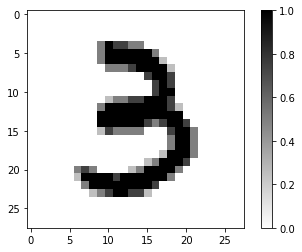

In [19]:
plt.imshow(val_scaled[1].reshape(28,28), cmap='gray_r')
plt.colorbar()
plt.show()

## 검증세트 두번째 (인덱스 1) 샘플의 예측결과를 확인

In [20]:
preds = model.predict(val_scaled[1:2])
print(preds)

1/1 [==============================] - 0s 101ms/step
[[2.08416574e-12 3.49166279e-10 1.00185950e-07 9.99999762e-01
  7.96956164e-12 5.74482826e-08 1.00682885e-14 5.98464434e-09
  2.31943775e-09 6.15213196e-08]]


## 위 예측결과를 그래프로 출력 후 확인

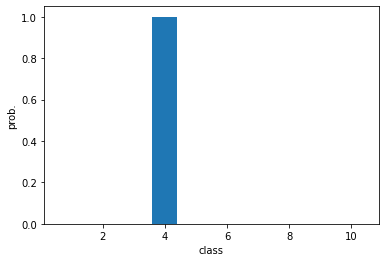

In [21]:
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [22]:
classes = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five',
           'Six', 'Seven', 'Eight', 'Nine']

In [23]:
import numpy as np
print(classes[np.argmax(preds)])

Three


##테스트 세트에 대한 성능을 평가해보자 (evaluate() 사용)

In [24]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

In [25]:
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 4s 14ms/step - loss: 0.0270 - accuracy: 0.9912


[0.027043549343943596, 0.9911999702453613]